# Glmnet Algorithm

In [1]:
import numpy as np
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plt

import seaborn as sns

sns.set()

In [2]:
def lasso_shrinkage(z, gamma):
    
    if gamma >= abs(z):
        return 0.0
    
    return (z/abs(z)) * (abs(z) - gamma)

In [3]:
# read data into iterable
x_list = []
labels = []
names = []
first_line = True
data_path = './data/winequality-red.csv'

with open(data_path) as data:
    
    for line in data:
        
        if first_line:
            names = line.strip().split(';')
            first_line = False
            
        else:
            # split on semicolon
            row = line.strip().split(';')
            
            # put labels in separate array
            labels.append(float(row[-1]))
            
            # remove label from row
            row.pop()
            
            # convert row to floats
            float_row = [float(num) for num in row]
            x_list.append(float_row)    

In [4]:
# Normalize columns in x and labels

n_rows = len(x_list)
n_cols = len(x_list[0])

# calculate means and variances
x_means = []
x_sd = []

for i in range(n_cols):
    col = [x_list[j][i] for j in range(n_rows)]
    mean = sum(col)/n_rows
    x_means.append(mean)
    
    col_diff = [(x_list[j][i] - mean) for j in range(n_rows)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_rows)])
    std_dev = sqrt(sum_sq/n_rows)
    x_sd.append(std_dev)
    
# use calculated mean and standard deviation to normalize x_list
x_normalized = []

for i in range(n_rows):
    row_normalized = [(x_list[i][j] - x_means[j])/x_sd[j] for j in range(n_cols)]
    x_normalized.append(row_normalized)
    
# Normalize labels
mean_label = sum(labels)/n_rows
sd_label = sqrt(sum([(labels[i] - mean_label) * (labels[i] - mean_label) for i in range(n_rows)])/n_rows)
label_normalized = [(labels[i] - mean_label)/sd_label for i in range(n_rows)]

# select value for alpha parameter
alpha = 1.0

# make a pass through the data to determine value of lambda that just suppresses all coefficients
# start with betas all equal to zero

xy = [0.0] * n_cols

for i in range(n_rows):
    
    for j in range(n_cols):
        xy[j] += x_normalized[i][j] * label_normalized[i]
        
max_xy = 0.0

for i in range(n_cols):
    val = abs(xy[i])/n_rows
    
    if val > max_xy:
        max_xy = val
        
# calculate starting value for lambda
lam = max_xy/alpha

# this value of lambda corresponds to beta list of zeroes
# initialize a vector of coefficients beta
beta = [0.0] * n_cols

# initialize matrix of betas at each step
beta_mat = []
beta_mat.append(list(beta))

In [5]:
# begin iteration
# 100 steps gives reduction by factor of 1000 in lambda (recommended by authors)
n_steps = 100
lam_mult = 0.93
nz_list = []

for i_step in range(n_steps):
    
    # make lambda smaller so that some coefficient becomes non-zero
    lam = lam * lam_mult

    delta_beta = 100.0
    eps = 0.01
    iter_step = 0
    beta_inner = list(beta)
    
    while delta_beta > eps:
        iter_step += 1
        
        if iter_step > 100:
            break
            
        # cycle through attributes and update one at a time
        # record starting value for comparison
        beta_start = list(beta_inner)
        
        for i_col in range(n_cols):
            xyj = 0.0
            
            for i in range(n_rows):
                # calculate residual with current value of beta
                label_hat = sum([x_normalized[i][k] * beta_inner[k] for k in range(n_cols)])
                residual = label_normalized[i] - label_hat
                
                xyj += x_normalized[i][i_col] * residual
                
            unc_beta = xyj/n_rows + beta_inner[i_col]
            beta_inner[i_col] = lasso_shrinkage(unc_beta, lam * alpha) / (1 + lam * (1 - alpha))
            
        sum_diff = sum([abs(beta_inner[n] - beta_start[n]) for n in range(n_cols)])
        sum_beta = sum([abs(beta_inner[n]) for n in range(n_cols)])
        delta_beta = sum_diff/sum_beta
        
    print(i_step, iter_step)
    beta = beta_inner
    
    # add newly determined beta to list
    beta_mat.append(beta)
    
    # keep track of the order in which the betas become non-zero
    nz_beta = [index for index in range(n_cols) if beta[index] != 0.0]
    
    for q in nz_beta:
        
        if not (q in nz_list):
            nz_list.append(q)

0 2
1 2
2 2
3 3
4 3
5 3
6 3
7 3
8 3
9 2
10 2
11 2
12 2
13 3
14 3
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 3
30 3
31 3
32 2
33 3
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 1
43 1
44 2
45 2
46 2
47 1
48 2
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1


['"alcohol"', '"volatile acidity"', '"sulphates"', '"total sulfur dioxide"', '"chlorides"', '"fixed acidity"', '"pH"', '"free sulfur dioxide"', '"residual sugar"', '"citric acid"', '"density"']


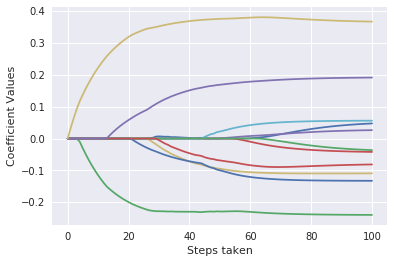

In [6]:
# print out the ordered list of betas
name_list = [names[nz_list[i]] for i in range(len(nz_list))]
print(name_list)

n_pts = len(beta_mat)

for i in range(n_cols):
    # plot range of beta values for each attribute
    coef_curve = [beta_mat[k][i] for k in range(n_pts)]
    x_axis = range(n_pts)
    plt.plot(x_axis, coef_curve)
    
plt.xlabel('Steps taken')
plt.ylabel('Coefficient Values')
plt.show()